In [ ]:
# !pip install rasterio

In [ ]:
# !pip install sdd-segmentation
# from sdd_segmentation.sdd import sdd_threshold_selection

In [ ]:
%%shell
wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
conda install -q -y --prefix /usr/local python=3.6 gdal

--2023-04-03 12:13:26--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   188MB/s    in 0.3s    

2023-04-03 12:13:27 (188 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6

In [ ]:
# !pip install imageio.v3

In [ ]:
# !pip install -U scikit-image

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
# from rasterio.plot import show

In [ ]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst


#FILENAME = r"1.tif"

In [ ]:
def show_image(image, path_to_save=None):
    f = plt.figure(figsize=(5, 5))  
    plt.imshow(image)
    plt.show()
    if path_to_save is not None:
        plt.imsave(f"{path_to_save}.png", image)  

In [ ]:
def get_image_RGB(filename):
    image = gdal.Open(filename)
    # As, there are 3 bands, we will store in 3 different variables 
    band_1 = image.GetRasterBand(1) # red channel  
    band_2 = image.GetRasterBand(2) # green channel  
    band_3 = image.GetRasterBand(3) # blue channel   
    #band_4 = image.GetRasterBand(4) # alpha channel
    b1 = band_1.ReadAsArray()  
    b2 = band_2.ReadAsArray()  
    b3 = band_3.ReadAsArray()
    # b4 = band_4.ReadAsArray()
    # Normalize input image to range [0, 255]
    normalized_b1 = cv2.normalize(b1, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    normalized_b2 = cv2.normalize(b2, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  
    normalized_b3 = cv2.normalize(b3, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return np.dstack((normalized_b1, normalized_b2, normalized_b3))


In [ ]:
# image_RGB = get_image_RGB(FILENAME)
# show_image(image_RGB)

In [ ]:
def print_info_image(filename):
    image = gdal.Open(filename)
    image_arr = image.ReadAsArray()
    print(f'Image as array:', f'dtype: {image_arr.dtype}, shape: {image_arr.shape}, min: {np.min(image_arr)}, max: {np.max(image_arr)}')
    print("Driver: {}/{}".format(image.GetDriver().ShortName,
                                image.GetDriver().LongName))
    print("Size is {} x {} x {}".format(image.RasterXSize,
                                        image.RasterYSize,
                                        image.RasterCount))
    print("Projection is {}".format(image.GetProjection()))
    print("Metadata: {}".format(image.GetMetadata()))
    geotransform = image.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
        

In [ ]:
# print_info_image(FILENAME)

In [ ]:
def otsu_method(image):
    # For debuging use cv2_imshow
    # Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
    # Use a bimodal image as an input.
    # Optimal threshold value is determined automatically.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # denoise the image with a Gaussian filter
    blurred_image = cv2.GaussianBlur(gray,(5,5),0)

    otsu_threshold, image_result = cv2.threshold(
        blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
    )

    # Remove noise and fill holes in the binary image using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    closed = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel)

    return closed


def draw_contours(thresh, image):
    # Find the contours in the input image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Draw the contours on an image
    contour_img = cv2.drawContours(image, contours, -1, (0, 255, 0), 5)

    return contour_img

In [ ]:
# %%time
# show_image(draw_contours(otsu_method(get_image_RGB(FILENAME)), get_image_RGB(FILENAME)))

In [ ]:
def connected_components(filename, sigma=1.0, connectivity=2):
    image = get_image_RGB(filename)

    closed = otsu_method(image)

    # perform connected component analysis
    # apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(closed, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    # initialize an output mask to store all forests parsed from
    # the image
    mask = np.zeros(image.shape, dtype="uint8")
    # loop over the number of unique connected component labels
    for i in range(1, numLabels):
      # extract the connected component statistics and centroid for
      # the current label
      x = stats[i, cv2.CC_STAT_LEFT]
      y = stats[i, cv2.CC_STAT_TOP]
      w = stats[i, cv2.CC_STAT_WIDTH]
      h = stats[i, cv2.CC_STAT_HEIGHT]
      area = stats[i, cv2.CC_STAT_AREA]
      # ensure the width, height, and area are all neither too small
      # nor too big
      keepWidth = w > 50
      keepHeight = h > 50
      keepArea = area > 250
      (cX, cY) = centroids[i]
      # ensure the connected component we are examining passes all
      # three tests
      if all((keepWidth, keepHeight, keepArea)):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        print("Area: {}, Width: {}, Height: {}".format(area, w, h))
        if i == 0:
          text = "examining component {}/{} (background)".format(
            i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
          text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        # clone our original image (so we can draw on it) and then draw
        # a bounding box surrounding the connected component along with
        # a circle corresponding to the centroid
        output = image.copy()
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        # construct a mask for the current connected component by
        # finding a pixels in the labels array that have the current
        # connected component ID
        componentMask = (labels == i).astype("uint8") * 255
        # show our output image and connected component mask
        show_image(output)
        show_image(componentMask)

#connected_components(r"15.tif", sigma=2.0, connectivity=8)

In [ ]:
def connected_components(filename, connectivity=2, path_to_save=None):
    image = get_image_RGB(filename)
    # clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    output_image = image.copy()
    # convert the image to grayscale
    closed = otsu_method(image)

    # perform connected component analysis
    # apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(closed, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    # initialize an output mask to store all forests parsed from
    # the image
    mask = np.zeros(image.shape, dtype="uint8")
    # loop over the number of unique connected component labels
    for i in range(1, numLabels):
      # extract the connected component statistics and centroid for
      # the current label
      x = stats[i, cv2.CC_STAT_LEFT]
      y = stats[i, cv2.CC_STAT_TOP]
      w = stats[i, cv2.CC_STAT_WIDTH]
      h = stats[i, cv2.CC_STAT_HEIGHT]
      area = stats[i, cv2.CC_STAT_AREA]
      # ensure the width, height, and area are all neither too small
      # nor too big
      keepWidth = w > 50
      keepHeight = h > 50
      keepArea = area > 250
      (cX, cY) = centroids[i]
      # ensure the connected component we are examining passes all
      # three tests
      if all((keepWidth, keepHeight, keepArea)):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        print("Area: {}, Width: {}, Height: {}".format(area, w, h))
        if i == 0:
          text = "examining component {}/{} (background)".format(
            i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
          text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.circle(output_image, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    # show our output image and connected component mask
    show_image(output_image)
    if path_to_save is not None:
        plt.imsave(f"{path_to_save}.png", output_image)



In [ ]:
#connected_components(r"16.tif", connectivity=8) # sigma=2.0, 

In [ ]:
def NDVI(image_file, t_pixel_forest=0.3, t_is_forest=0.5):
    ds = gdal.Open(image_file)
    red_band = ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
    # If there is NIR_band on the second band we use NIR_band, if not, then we use green
    NIR_band = ds.GetRasterBand(4).ReadAsArray().astype(np.float32) 

    # calculate NDVI
    ndvi = (NIR_band - red_band) / (NIR_band + red_band)

    # classify pixels as forest or non-forest based on a threshold value
    forest_mask = np.where(ndvi >= t_pixel_forest, 1, 0)
    forest_percent = np.average(forest_mask)
    print(forest_percent)
    
    # classify the image based on the percentage of forest cover
    is_forest = True
    if forest_percent >= t_is_forest:
        print('The image contains a forest')
    else:
        is_forest = False
        print('The image does not contain a forest')

    return is_forest

# NDVI(r"test.tif")
# NDVI(FILENAME)

In [ ]:
show_image(get_image_RGB(r"2.tif"))

AttributeError: ignored

In [ ]:
def main(image_file):
  if NDVI(image_file):
    connected_components(image_file)
    show_image(draw_contours(otsu_method(get_image_RGB(image_file)), get_image_RGB(image_file)))
  else:
    show_image(get_image_RGB(image_file))

#main(r"test.tif")

In [ ]:
def spectral_signatures():
  pass

In [ ]:
def get_4_band(image_file):
    ds = gdal.Open(image_file)
    return ds.GetRasterBand(4).ReadAsArray().astype(np.float32)

#get_4_band(FILENAME)

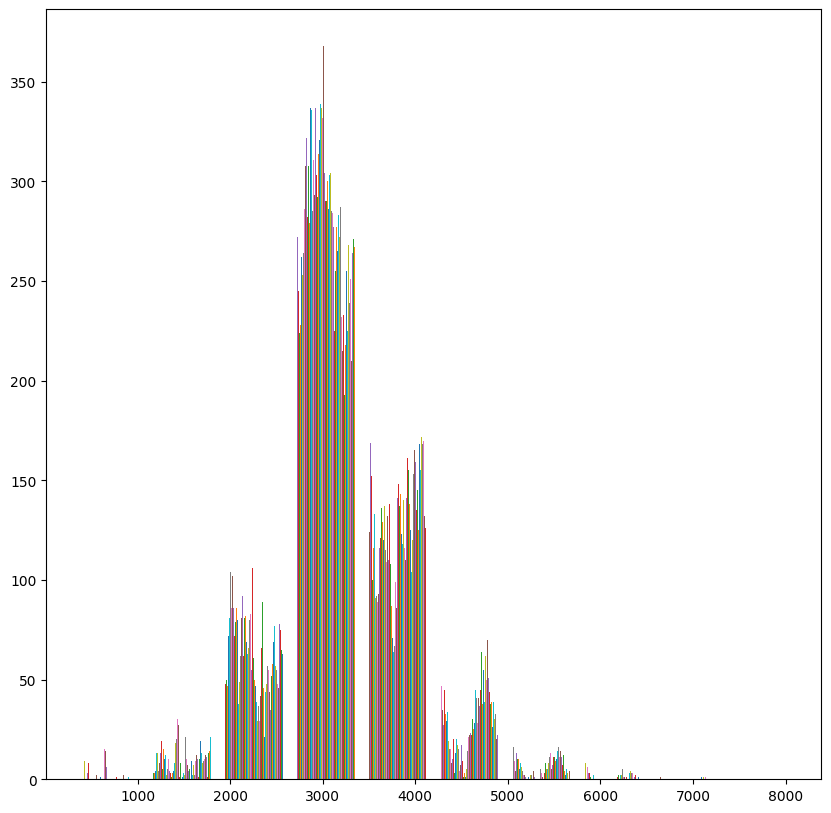

In [ ]:
f = plt.figure(figsize=(10, 10)) 
plt.hist(get_4_band(FILENAME)) 
# plt.imshow(get_image_RGB(FILENAME))
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes(get_4_band(FILENAME))
# plt.colorbar(cax=cax)
plt.show() 


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight

# Efficient net without augmentation4
class EfficientNetModel:
    metrics_names = ['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc']
    METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc'),
          tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.base_model = tf.keras.applications.efficientnet.EfficientNetB2(input_shape=self.input_shape, include_top=False, weights='imagenet')
        self.data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            tf.keras.layers.RandomContrast(factor=0.1),
            ],
            name="img_augmentation",
            )
        self.model = self.build_model()
        
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = self.data_augmentation(inputs)
        x = self.base_model(x)
        
        for layer in self.base_model.layers[:40]:  #-20
            # if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
                
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        predictions = tf.keras.layers.Dense(self.num_classes, activation='sigmoid')(x)  # !!
        model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
        return model

     
    def compile(self, learning_rate = 0.0001):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=self.METRICS)  
    
    def evaluate(self, data):
        return self.model.evaluate(data)
    
    def predict(self, data):
        return self.model.predict(data)
    
    def summary(self):
        return self.model.summary()
    
    def save_model(self, filepath):
        self.model.save(filepath)
        
    def load_model(self, model_path):
        self.model.load_weights(model_path)
        
    def plot_model_architecture(self, file_path):
        tf.keras.utils.plot_model(self, to_file=file_path, show_shapes=True)
        


In [ ]:
# os.environ['TF_KERAS'] = '1'

# load the model
model = EfficientNetModel(input_shape=(64, 64, 3), num_classes=1)
model.load_model('efficientB2_model.h5')

# define the input image size
input_size = (64, 64)

31790344/31790344 [==============================] - 2s 0us/step


2/2 [==============================] - 1s 393ms/step
0.640625
Area: 35739, Width: 217, Height: 281
[INFO] examining component 2/29
Area: 7421, Width: 100, Height: 156
[INFO] examining component 3/29
Area: 10217, Width: 101, Height: 162
[INFO] examining component 5/29
Area: 7966, Width: 123, Height: 89
[INFO] examining component 6/29
Area: 2162, Width: 61, Height: 76
[INFO] examining component 9/29
Area: 70982, Width: 413, Height: 384
[INFO] examining component 11/29
Area: 1679, Width: 65, Height: 57
[INFO] examining component 17/29


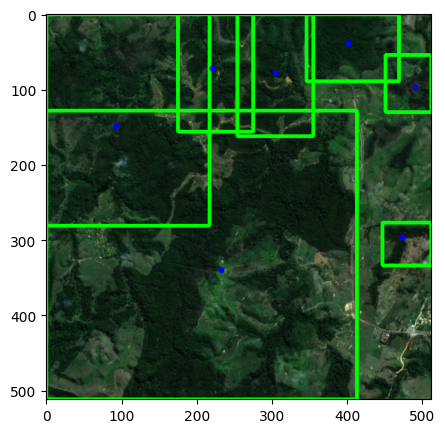

--------------------
2/2 [==============================] - 1s 264ms/step
0.64970076
Area: 81293, Width: 242, Height: 512
[INFO] examining component 6/43
Area: 30957, Width: 257, Height: 215
[INFO] examining component 19/43
Area: 3235, Width: 59, Height: 90
[INFO] examining component 35/43


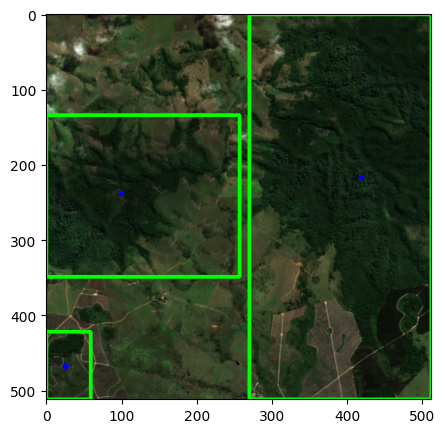

--------------------
2/2 [==============================] - 1s 273ms/step
0.851351
Area: 1250, Width: 66, Height: 51
[INFO] examining component 2/14
Area: 203927, Width: 512, Height: 512
[INFO] examining component 3/14


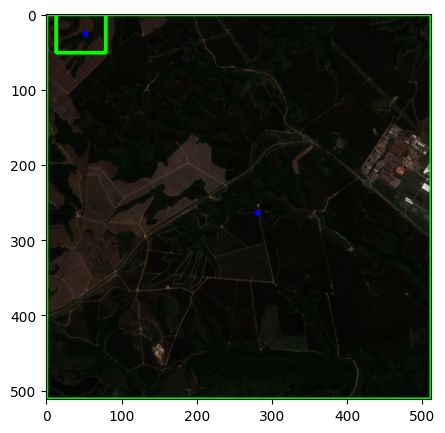

--------------------
2/2 [==============================] - 1s 435ms/step
0.40784085
Area: 15612, Width: 432, Height: 93
[INFO] examining component 3/52
Area: 11786, Width: 177, Height: 138
[INFO] examining component 11/52
Area: 11860, Width: 146, Height: 152
[INFO] examining component 13/52
Area: 3393, Width: 71, Height: 79
[INFO] examining component 23/52
Area: 5412, Width: 98, Height: 116
[INFO] examining component 28/52
Area: 51389, Width: 306, Height: 351
[INFO] examining component 31/52
Area: 28308, Width: 226, Height: 263
[INFO] examining component 37/52
Area: 2611, Width: 65, Height: 103
[INFO] examining component 42/52
Area: 4919, Width: 115, Height: 146
[INFO] examining component 48/52


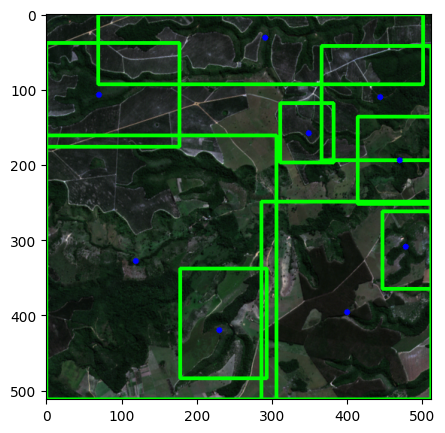

--------------------
2/2 [==============================] - 1s 338ms/step
0.04684537


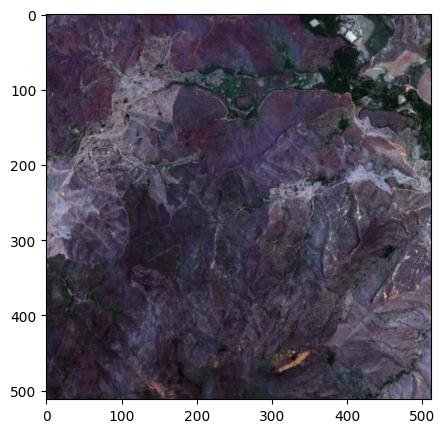

--------------------
2/2 [==============================] - 1s 480ms/step
0.041391727


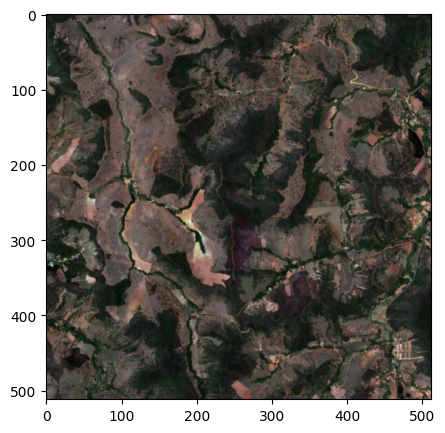

--------------------
2/2 [==============================] - 1s 384ms/step
0.34375
Area: 15655, Width: 203, Height: 167
[INFO] examining component 2/63
Area: 3614, Width: 72, Height: 81
[INFO] examining component 21/63
Area: 2888, Width: 70, Height: 61
[INFO] examining component 33/63
Area: 2108, Width: 70, Height: 56
[INFO] examining component 35/63
Area: 7963, Width: 148, Height: 161
[INFO] examining component 36/63
Area: 3738, Width: 71, Height: 90
[INFO] examining component 38/63
Area: 12867, Width: 191, Height: 157
[INFO] examining component 39/63
Area: 4915, Width: 168, Height: 79
[INFO] examining component 49/63


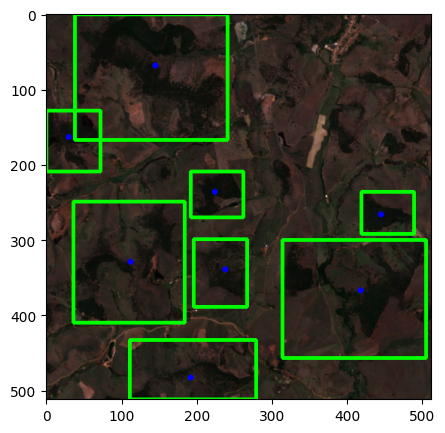

--------------------
2/2 [==============================] - 1s 456ms/step
0.5
Area: 5117, Width: 120, Height: 68
[INFO] examining component 2/29
Area: 100807, Width: 495, Height: 512
[INFO] examining component 3/29
Area: 4837, Width: 122, Height: 86
[INFO] examining component 20/29


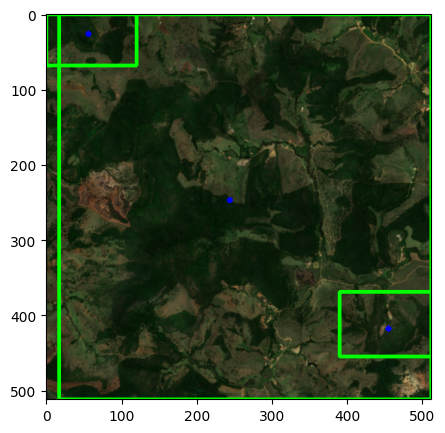

--------------------
2/2 [==============================] - 1s 424ms/step
0.20671797


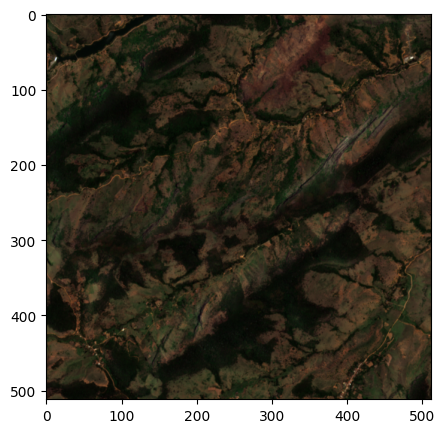

--------------------
2/2 [==============================] - 1s 437ms/step
0.5370239
Area: 19927, Width: 180, Height: 189
[INFO] examining component 7/72
Area: 75629, Width: 490, Height: 429
[INFO] examining component 21/72
Area: 4124, Width: 65, Height: 112
[INFO] examining component 32/72
Area: 2816, Width: 149, Height: 71
[INFO] examining component 44/72


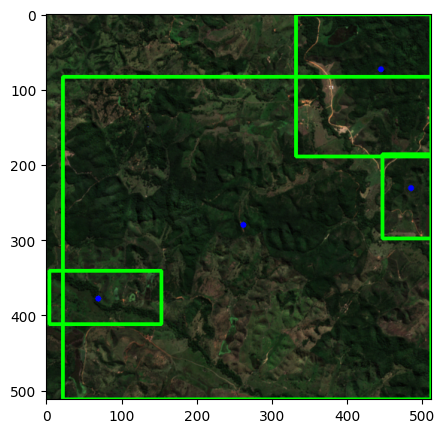

--------------------
2/2 [==============================] - 1s 451ms/step
0.90625
Area: 69088, Width: 338, Height: 512
[INFO] examining component 2/41
Area: 1691, Width: 68, Height: 53
[INFO] examining component 4/41
Area: 2892, Width: 86, Height: 118
[INFO] examining component 6/41
Area: 15543, Width: 158, Height: 281
[INFO] examining component 7/41
Area: 1686, Width: 64, Height: 60
[INFO] examining component 14/41
Area: 3013, Width: 103, Height: 57
[INFO] examining component 27/41
Area: 4714, Width: 89, Height: 126
[INFO] examining component 29/41
Area: 8223, Width: 162, Height: 115
[INFO] examining component 30/41


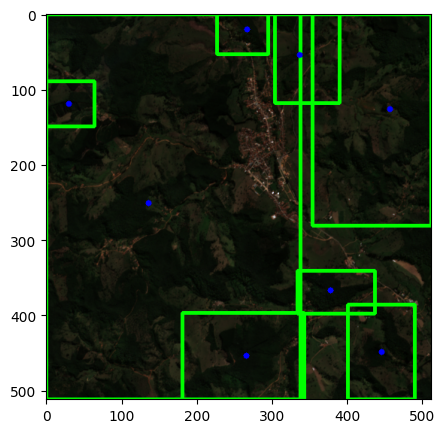

--------------------
2/2 [==============================] - 1s 414ms/step
0.32204193
Area: 3288, Width: 143, Height: 51
[INFO] examining component 3/45
Area: 25078, Width: 257, Height: 155
[INFO] examining component 4/45
Area: 3075, Width: 98, Height: 70
[INFO] examining component 13/45
Area: 12321, Width: 127, Height: 182
[INFO] examining component 14/45
Area: 6832, Width: 104, Height: 141
[INFO] examining component 29/45
Area: 47764, Width: 394, Height: 240
[INFO] examining component 34/45
Area: 13464, Width: 128, Height: 219
[INFO] examining component 38/45


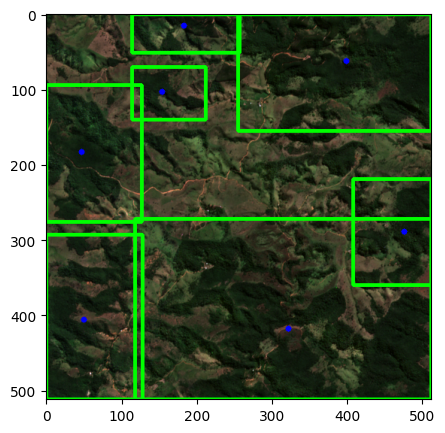

--------------------
2/2 [==============================] - 1s 294ms/step
0.43645692
Area: 55287, Width: 305, Height: 512
[INFO] examining component 5/69
Area: 8018, Width: 107, Height: 192
[INFO] examining component 10/69
Area: 4911, Width: 82, Height: 92
[INFO] examining component 30/69
Area: 4650, Width: 138, Height: 104
[INFO] examining component 45/69
Area: 3280, Width: 98, Height: 71
[INFO] examining component 51/69
Area: 6861, Width: 190, Height: 71
[INFO] examining component 58/69


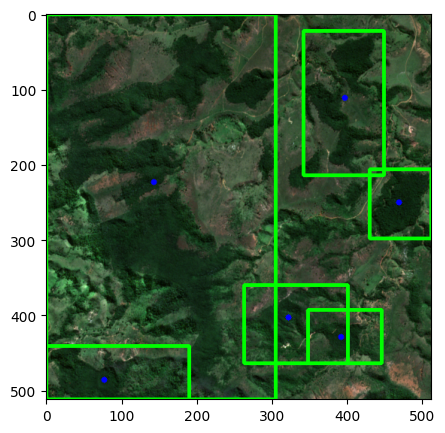

--------------------
2/2 [==============================] - 1s 278ms/step
0.28635567


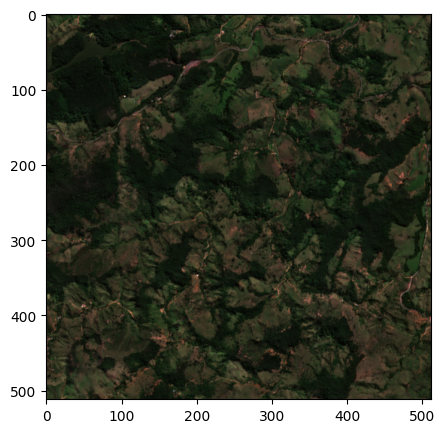

--------------------
2/2 [==============================] - 1s 293ms/step
0.4084664
Area: 3014, Width: 70, Height: 68
[INFO] examining component 3/25
Area: 131721, Width: 512, Height: 512
[INFO] examining component 5/25
Area: 1457, Width: 64, Height: 63
[INFO] examining component 7/25
Area: 7290, Width: 103, Height: 137
[INFO] examining component 12/25


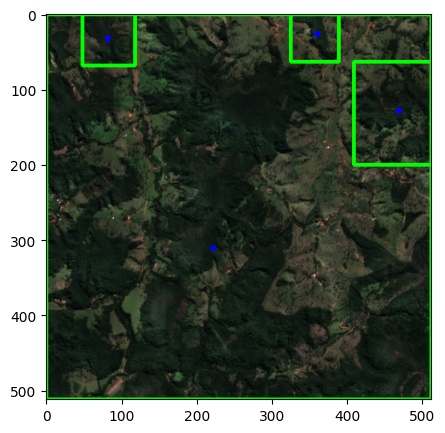

--------------------
2/2 [==============================] - 1s 281ms/step
0.09651992


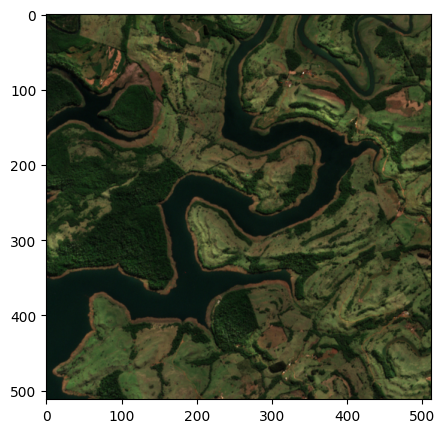

--------------------
2/2 [==============================] - 1s 338ms/step
0.84375
Area: 16536, Width: 162, Height: 215
[INFO] examining component 2/56
Area: 13339, Width: 118, Height: 203
[INFO] examining component 7/56
Area: 9083, Width: 146, Height: 168
[INFO] examining component 8/56
Area: 3276, Width: 71, Height: 92
[INFO] examining component 11/56
Area: 24825, Width: 234, Height: 288
[INFO] examining component 18/56
Area: 52587, Width: 458, Height: 345
[INFO] examining component 23/56
Area: 3090, Width: 117, Height: 84
[INFO] examining component 40/56
Area: 7519, Width: 173, Height: 93
[INFO] examining component 43/56


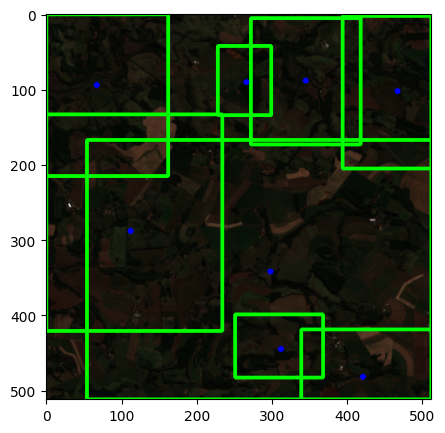

--------------------
2/2 [==============================] - 1s 286ms/step
0.78125
Area: 30136, Width: 303, Height: 267
[INFO] examining component 5/70
Area: 4085, Width: 106, Height: 81
[INFO] examining component 8/70
Area: 2525, Width: 92, Height: 59
[INFO] examining component 13/70
Area: 2984, Width: 74, Height: 75
[INFO] examining component 21/70
Area: 4987, Width: 98, Height: 111
[INFO] examining component 34/70
Area: 8465, Width: 125, Height: 201
[INFO] examining component 41/70
Area: 18707, Width: 205, Height: 223
[INFO] examining component 45/70
Area: 3395, Width: 75, Height: 82
[INFO] examining component 56/70
Area: 4621, Width: 104, Height: 84
[INFO] examining component 57/70
Area: 3329, Width: 80, Height: 80
[INFO] examining component 62/70
Area: 3768, Width: 106, Height: 62
[INFO] examining component 65/70


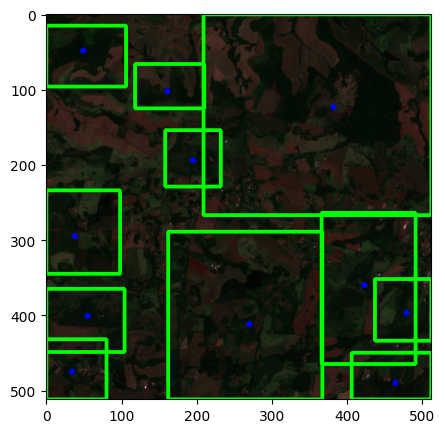

--------------------
2/2 [==============================] - 1s 304ms/step
0.921875
Area: 208850, Width: 512, Height: 512
[INFO] examining component 2/14


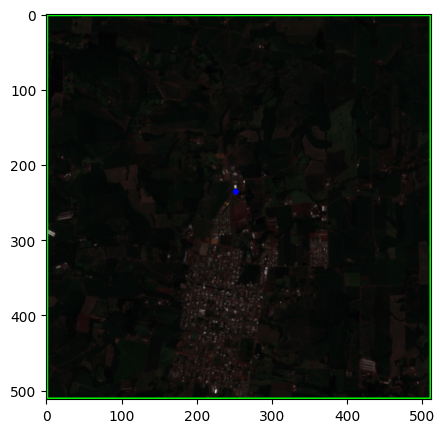

--------------------
2/2 [==============================] - 1s 462ms/step
0.46968305
Area: 39624, Width: 341, Height: 309
[INFO] examining component 3/58
Area: 1981, Width: 64, Height: 53
[INFO] examining component 15/58
Area: 2921, Width: 53, Height: 101
[INFO] examining component 16/58
Area: 7126, Width: 135, Height: 118
[INFO] examining component 21/58
Area: 3241, Width: 61, Height: 99
[INFO] examining component 27/58
Area: 26501, Width: 226, Height: 259
[INFO] examining component 35/58
Area: 3835, Width: 94, Height: 92
[INFO] examining component 36/58
Area: 15365, Width: 190, Height: 215
[INFO] examining component 41/58
Area: 13095, Width: 154, Height: 175
[INFO] examining component 46/58


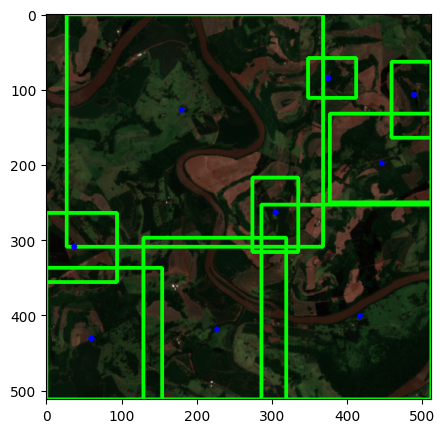

--------------------


In [ ]:
def crop_geotiff_to_jpeg(filename, out_dir, block_size):
    # read the input GeoTIFF file
    img = get_image_RGB(filename)
    images = []
    # predictions = []
    

    # set the output directory
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # loop through each block and save as a separate JPEG file
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            # calculate the pixel coordinates of the block
            ulx = i
            uly = j
            lrx = i + block_size
            lry = j + block_size

            # make sure the block is within the image bounds
            if lrx > img.shape[0]:
                lrx = img.shape[0]
                ulx = lrx - block_size
            if lry > img.shape[1]:
                lry = img.shape[1]
                uly = lry - block_size

            # crop the block and save as a JPEG file
            out_file = os.path.join(out_dir, f'{i}_{j}.jpg')
            block = img[ulx:lrx, uly:lry, :]

            # потом закомментить
            # cv2.imwrite(out_file, block)

            # image = cv2.imread(out_file)
            # image = cv2.resize(image, input_size)

            image = cv2.resize(block, input_size)
            # normalize pixel values to [0, 1]
            image = image.astype('float32') / 255.0 

            # image_arr = (image * 255).astype("uint8")
            # show_image(image_arr)

            # prediction = model.predict(np.expand_dims(image, axis = 0))
            # predicted_label = prediction.item()
            # print(predicted_label)

            # predictions.append(predicted_label)

            images.append(image)
    
    return np.array(images)


def predict(images, t=0.1):
    prediction = model.predict(images)
    apply_threshold = np.vectorize(lambda x, t: 1 if x >= t else x)
    prediction = apply_threshold(prediction, t)
    return prediction.mean()


def look_all_files(folder_path, path_to_save, main_t=0.5):
    # Пройдите по всей папке
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            # Вывод имени и пути к файлу
            FILENAME = os.path.join(root, filename)
            images = crop_geotiff_to_jpeg(FILENAME, 'output', 64)
            #show_image(get_image_RGB(FILENAME))
            pred = predict(images)
            print(pred)
            filename_save = path_to_save + str(round(pred, 3))
            if pred >= main_t:
                connected_components(FILENAME, path_to_save=filename_save, connectivity=8)
            else:
                show_image(get_image_RGB(FILENAME), path_to_save=filename_save)
            print("-"*20)

# Установите имя и путь к папке
folder_name = 'pred_and_CCA/'
path_to_save = '/content/' + folder_name 

# Создайте новую папку, если она не существует
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)



look_all_files('/content/drive/MyDrive/test_forest', path_to_save, main_t=0.3)

In [ ]:
# import shutil
# import os

# # Установите имя и путь к папке, которую нужно удалить
# folder_name = 'pred_and_CCA'
# path = '/content/' + folder_name

# # Удалите папку, если она существует
# if os.path.exists(path):
#     shutil.rmtree(path)
#     print('Папка удалена:', path)
# else:
#     print('Папка не существует:', path)
!zip -r pred_and_CCA.zip  '/content/pred_and_CCA/'


  adding: content/pred_and_CCA/ (stored 0%)
  adding: content/pred_and_CCA/0.922.png (deflated 0%)
  adding: content/pred_and_CCA/0.5.png (deflated 0%)
  adding: content/pred_and_CCA/0.781.png (deflated 0%)
  adding: content/pred_and_CCA/0.207.png (deflated 0%)
  adding: content/pred_and_CCA/0.47.png (deflated 0%)
  adding: content/pred_and_CCA/0.65.png (deflated 0%)
  adding: content/pred_and_CCA/0.047.png (deflated 0%)
  adding: content/pred_and_CCA/0.286.png (deflated 0%)
  adding: content/pred_and_CCA/0.851.png (deflated 0%)
  adding: content/pred_and_CCA/0.844.png (deflated 0%)
  adding: content/pred_and_CCA/0.906.png (deflated 0%)
  adding: content/pred_and_CCA/0.322.png (deflated 0%)
  adding: content/pred_and_CCA/0.408.png (deflated 0%)
  adding: content/pred_and_CCA/0.097.png (deflated 0%)
  adding: content/pred_and_CCA/0.041.png (deflated 0%)
  adding: content/pred_and_CCA/0.436.png (deflated 0%)
  adding: content/pred_and_CCA/0.641.png (deflated 0%)
  adding: content/pred_an

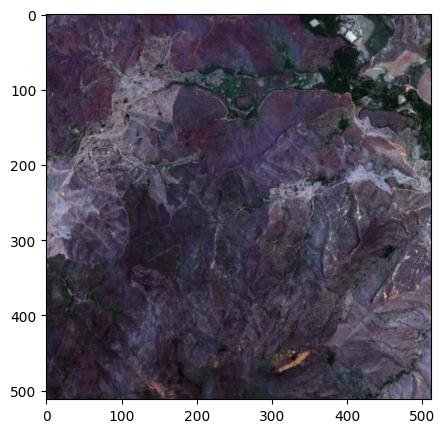

2/2 [==============================] - 1s 378ms/step


0.0

In [ ]:
FILENAME = r"not_forest.tif"
show_image(get_image_RGB(FILENAME))
images = crop_geotiff_to_jpeg(FILENAME, 'output', 64)
predict(images)

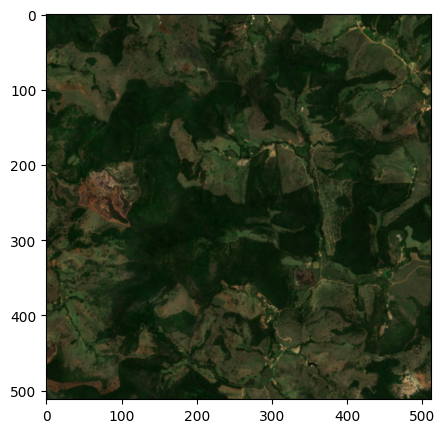

2/2 [==============================] - 1s 398ms/step


0.046875

In [ ]:
FILENAME = r"idk.tif"
show_image(get_image_RGB(FILENAME))
images = crop_geotiff_to_jpeg(FILENAME, 'output', 64)
predict(images)

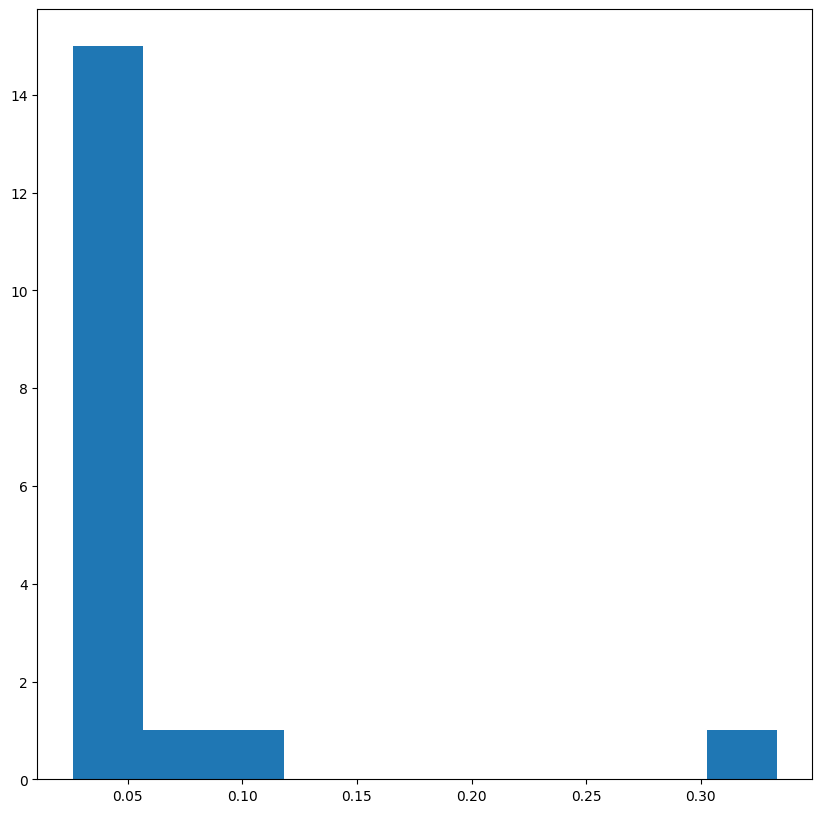

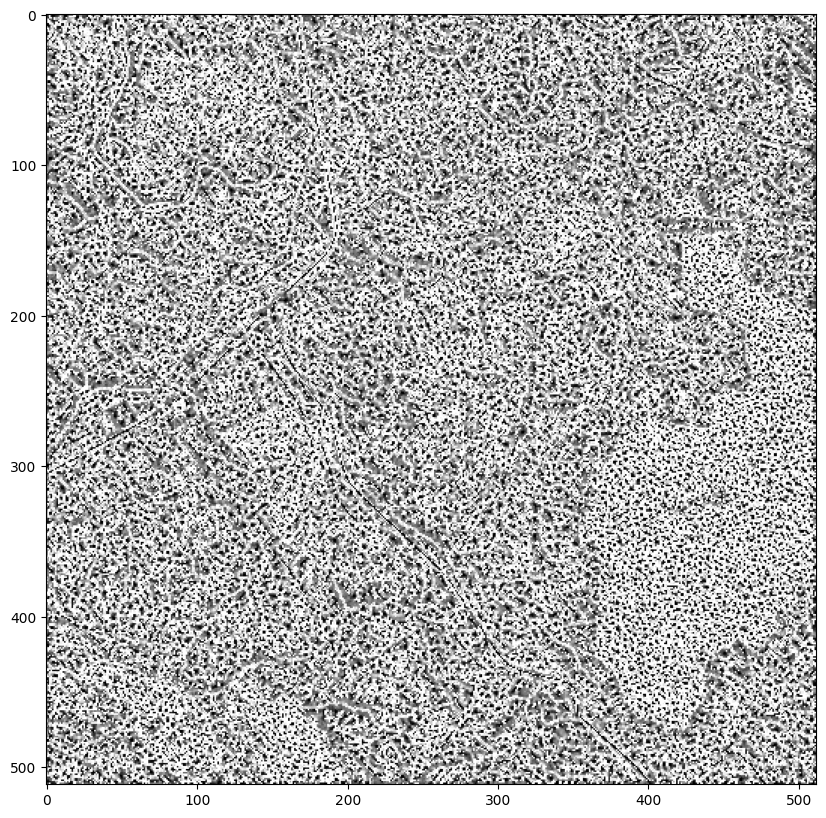

In [ ]:
from skimage import feature
import numpy as np


class LocalBinaryPatterns:
    def __init__(self, image, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.lbp = feature.local_binary_pattern(gray, self.numPoints,
          self.radius, method="uniform")


    def describe(self, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        
        (hist, _) = np.histogram(self.lbp.ravel(),
          bins=np.arange(0, self.numPoints + 3),
          range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist
    
    def show_hist(self):
        f = plt.figure(figsize=(10, 10)) 
        plt.hist(self.describe()) 
        plt.show()
    
    def show_texture_image(self):
        f = plt.figure(figsize=(10, 10)) 
        plt.imshow(self.lbp.astype("uint8"), cmap="gray") 
        plt.show() 



def texture_analysis(r, n_points):
    radius = 2
    n_points = 8 * radius 
    lbp = LocalBinaryPatterns(get_image_RGB(FILENAME), n_points, radius)
    lbp.show_hist()
    lbp.show_texture_image()




radius = 2
n_points = 8 * radius
texture_analysis(radius, n_points)